In [14]:
!pip install datasets qqdm

# Note: this is cloning from the dataset call the LSUN which is mainly for the bed image generating. the dataset have around 0.3M of examples.

In [15]:
from datasets import load_dataset
import shutil
import os

path = os.path.join("./", 'logs')
os.makedirs(path, exist_ok=True)

# Define dataset path
path_data = "data"
os.makedirs(path_data, exist_ok=True)

# Download LSUN Bedroom dataset
url = 'https://s3.amazonaws.com/fast-ai-imageclas/bedroom.tgz'
path_zip = os.path.join(path_data, "bedroom.tgz")

if not os.path.exists(path_zip):
    !wget {url} -O {path_zip}
    shutil.unpack_archive(path_zip, path_data)


In [16]:
print(os.getcwd())

/content


In [17]:
print(os.listdir("/content/data/bedroom/"))

['1', 'f', '3', 'c', '7', '6', '5', '0', 'd', '9', 'a', '2', '4', '8', 'e', 'b']


In [18]:
import random
import torch
import numpy as np
from torchvision import datasets
import os
import glob
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm

In [19]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
train_dataset = datasets.ImageFolder(root="/content/data/bedroom/", transform=transform)

In [20]:
#see how many data here
print(len(train_dataset))

303125


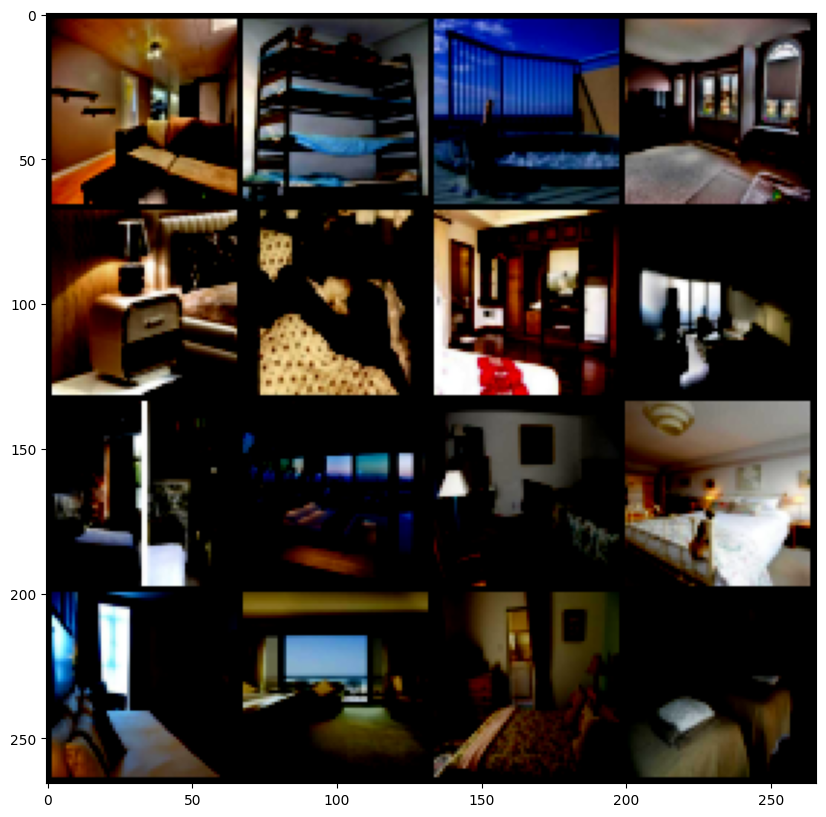

In [21]:
#see some example of dataset
images=[train_dataset[i][0] for i in range(16)]
grid_img=torchvision.utils.make_grid(images,nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1,2,0))
plt.show()

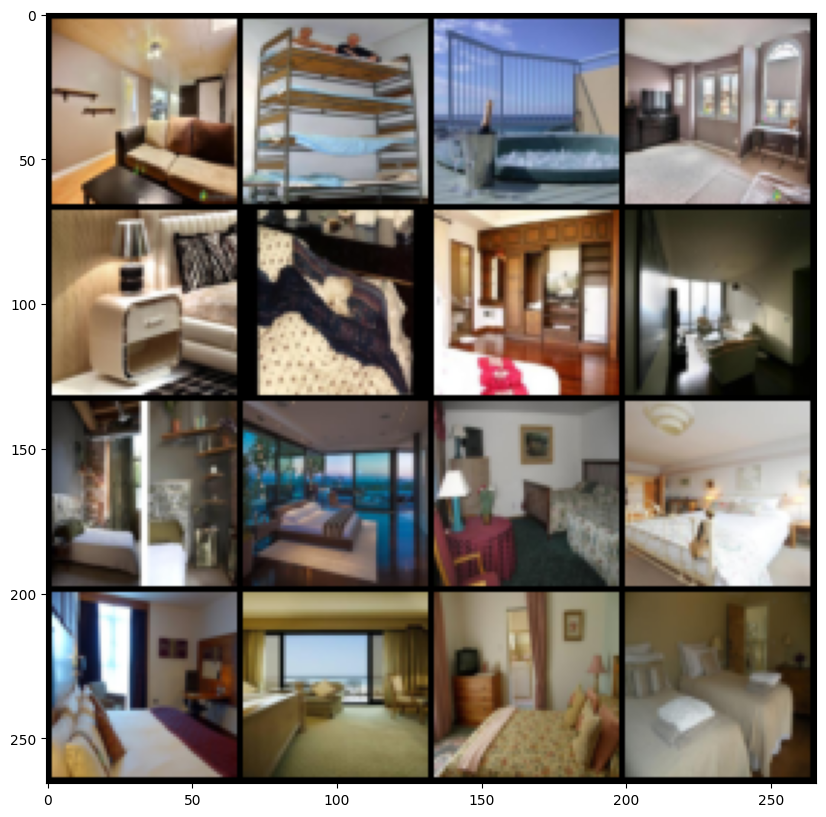

In [22]:
good_images=[(train_dataset[i][0]+1)/2 for i in range(16)]
good_grid_img=torchvision.utils.make_grid(good_images,nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(good_grid_img.permute(1,2,0))
plt.show()

In [23]:
dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

In [24]:
for batch in dataloader:
    images, _ = batch  # Get images without labels
    print(images.shape)
    break

torch.Size([128, 3, 64, 64])


In [25]:
#make the model
def weigth_init(layer):
  layer_name=layer.__class__.__name__

  if "Conv" in layer_name:
    layer.weight.data.normal_(mean=0.0,std=0.02)
  elif "BatchNorm" in layer_name:
    layer.weight.data.normal_(mean=1.0,std=0.02)
    layer.bias.data.fill_(0)

class Generator(nn.Module):
  def __init__(self,in_dim,dim=128):
    super(Generator,self).__init__()
    def conv_batch_relu(in_dim,out_dim):
      return nn.Sequential(
          nn.ConvTranspose2d(in_dim,out_dim,5,2,2,1,bias=False),
          nn.BatchNorm2d(out_dim),
          nn.ReLU()
      )
    self.project_layer=nn.Sequential(
        nn.Linear(in_dim,dim*8*4*4,bias=False),
        nn.BatchNorm1d(dim*8*4*4),
        nn.ReLU()
    )
    self.con_layer=nn.Sequential(
        conv_batch_relu(dim*8,dim*4),
        conv_batch_relu(dim*4,dim*2),
        conv_batch_relu(dim*2,dim),
        nn.ConvTranspose2d(dim,3,5,2,2,1),
        nn.Tanh()
    )
    self.apply(weigth_init)

  def forward(self,x):
    y=self.project_layer(x)
    y=y.view(y.shape[0],-1,4,4)

    y=self.con_layer(y)

    return y

class Discriminator(nn.Module):
  def __init__(self,in_dim,dim=128):
    super(Discriminator, self).__init__()

    def conv_batch_Leakyrelu(in_dim,out_dim):
      return nn.Sequential(
          nn.Conv2d(in_dim, out_dim, 5, 2, 2),
          nn.BatchNorm2d(out_dim),
          nn.LeakyReLU(0.2),
      )

    self.con_layer=nn.Sequential(
        nn.Conv2d(in_dim,dim,5,2,2),
        nn.LeakyReLU(0.2),
        conv_batch_Leakyrelu( dim , dim*2),
        conv_batch_Leakyrelu( dim*2 , dim*4),
        conv_batch_Leakyrelu( dim*4 , dim*8),
        nn.Conv2d( dim*8 , 1, 4),
        nn.Sigmoid(),
    )
  def forward(self,x):
    y=self.con_layer(x)
    y=y.view(-1)
    return y

In [26]:
#training
batch_size=128
z_dim=100

#this z_sample is for printing the resulf of training in intermiideate step
z_sample=torch.randn(50, z_dim).cuda()
lr = 1e-4

num_epoch=10
n_critic = 1

G=Generator(in_dim=z_dim).cuda()
D=Discriminator(3).cuda()

G.train()
D.train()

Loss=nn.BCELoss()

opt_D = torch.optim.Adam(D.parameters(), lr=lr,betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G.parameters(), lr=lr,betas=(0.5, 0.999))

In [27]:
ckpt_dir='./checkpoints'
os.makedirs(ckpt_dir, exist_ok=True)

In [28]:
G.load_state_dict(torch.load(os.path.join(ckpt_dir, 'G4.pth')))
D.load_state_dict(torch.load(os.path.join(ckpt_dir, 'D4.pth')))

<All keys matched successfully>

   Iters      Elapsed Time      Speed    D_loss  G_loss  Epoch  step            
 2369/2369  00:42:50<00:00:00  0.92it/s  0.0674  2.613     1    2369            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

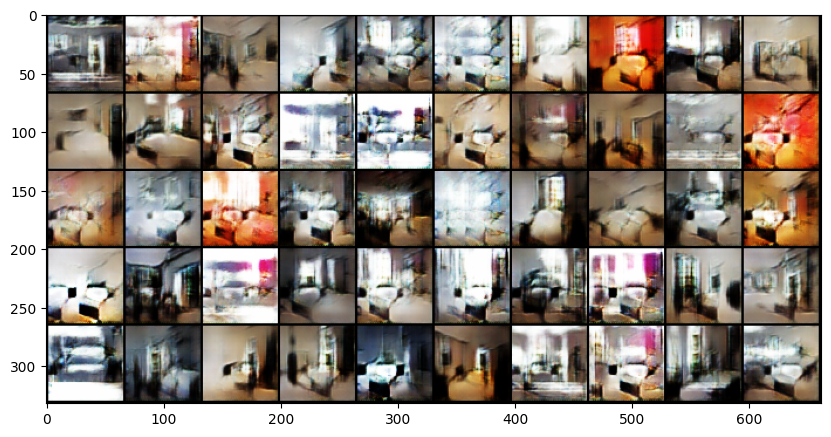

   Iters      Elapsed Time      Speed    D_loss  G_loss  Epoch  step            
 2369/2369  00:42:51<00:00:00  0.92it/s  0.0565  8.1593    2    4738            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

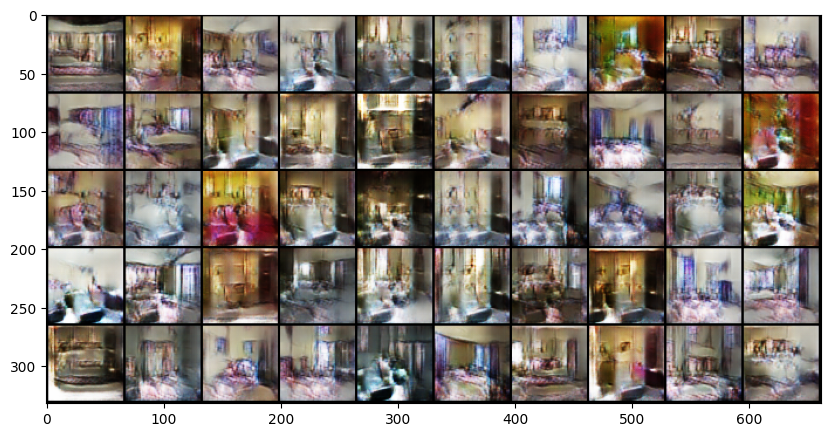

   Iters      Elapsed Time      Speed    D_loss  G_loss  Epoch  step            
 2369/2369  00:42:51<00:00:00  0.92it/s  0.0088  3.2791    3    7107            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

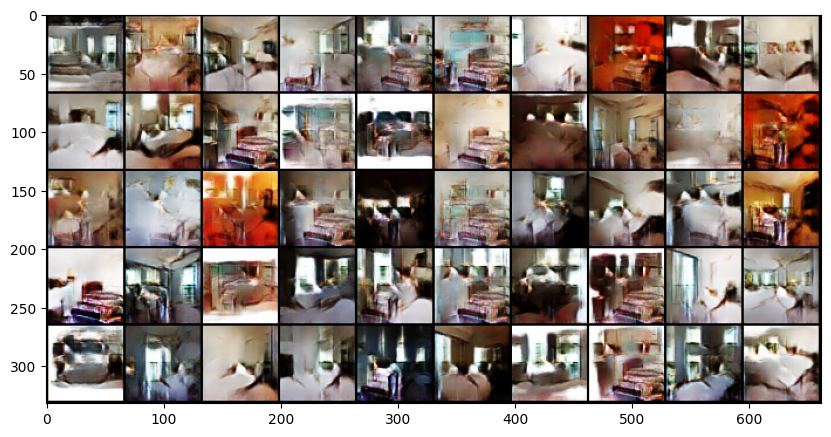

   Iters      Elapsed Time      Speed    D_loss  G_loss   Epoch  step           
 2369/2369  00:42:51<00:00:00  0.92it/s  0.0577  11.3672    4    9476           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

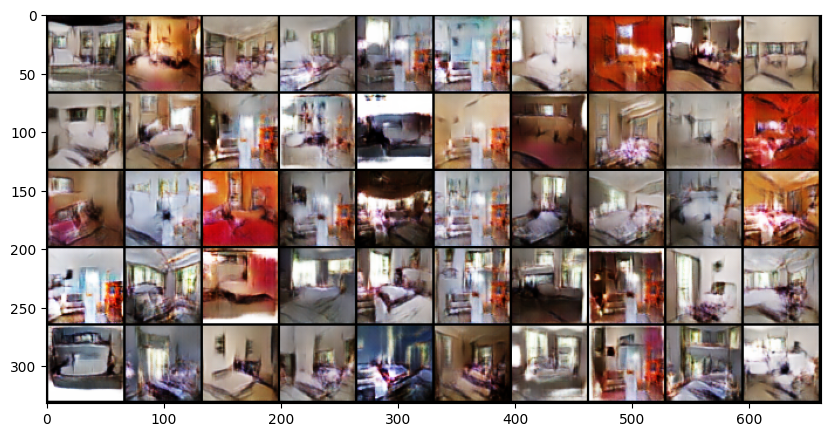

  Iters     Elapsed Time      Speed    D_loss  G_loss  Epoch  step              
 11/2369  00:00:12<00:45:11  0.87it/s  0.065   8.5595    5    9487              

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

KeyboardInterrupt: 

In [29]:
step=0
for e,epoch in enumerate(range(num_epoch)):
  qqdm_bar=qqdm(dataloader)
  for i, data in enumerate(qqdm_bar):
    imgs,_=data
    imgs=imgs.cuda()

    batch_size=imgs.shape[0]

    #training the discriminator while freezing the genraor
    noise=torch.randn(batch_size,z_dim).cuda()
    real_imgs=imgs.cuda()
    fake_imgs=G(noise)

    real_logit=D(real_imgs)
    fake_logit=D(fake_imgs)

    real_label=torch.ones((batch_size)).cuda()
    fake_label=torch.zeros((batch_size)).cuda()

    loss_from_real=Loss(real_logit,real_label)
    loss_from_fake=Loss(fake_logit,fake_label)
    D_batch_loss=(loss_from_real+loss_from_fake)/2
    D.zero_grad()
    D_batch_loss.backward()
    opt_D.step()

    #training the generator only
    noise=torch.randn(batch_size,z_dim).cuda()

    fake_imgs=G(noise)
    fake_logit=D(fake_imgs)
    G_batch_loss=Loss(fake_logit,real_label)
    G.zero_grad()
    G_batch_loss.backward()
    opt_G.step()

    step+=1


    qqdm_bar.set_infos({
        "D_loss":round(D_batch_loss.item(),4),
        "G_loss":round(G_batch_loss.item(),4),
        "Epoch":e+1,
        "step":step
    })
  G.eval()
  f_imgs_sample = (G(z_sample).data + 1) / 2.0
  gird_imgs=torchvision.utils.make_grid(f_imgs_sample.cpu(),nrow=10)
  plt.figure(figsize=(10,10))
  plt.imshow(gird_imgs.permute(1,2,0))
  plt.show()
  G.train()

  if (e+1) % 5 == 0 or e == 0:
    # Save the checkpoints.
    torch.save(G.state_dict(), os.path.join(ckpt_dir, 'G.pth'))
    torch.save(D.state_dict(), os.path.join(ckpt_dir, 'D.pth'))


In [30]:
torch.save(G.state_dict(), os.path.join(ckpt_dir, 'G8.pth'))
torch.save(D.state_dict(), os.path.join(ckpt_dir, 'D8.pth'))

# we need to save before the session terminated

In [31]:
import torch
G=Generator(in_dim=z_dim)
G.load_state_dict(torch.load(os.path.join(ckpt_dir, 'G8.pth')))
G.eval()
G.cuda()

Generator(
  (project_layer): Sequential(
    (0): Linear(in_features=100, out_features=16384, bias=False)
    (1): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (con_layer): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

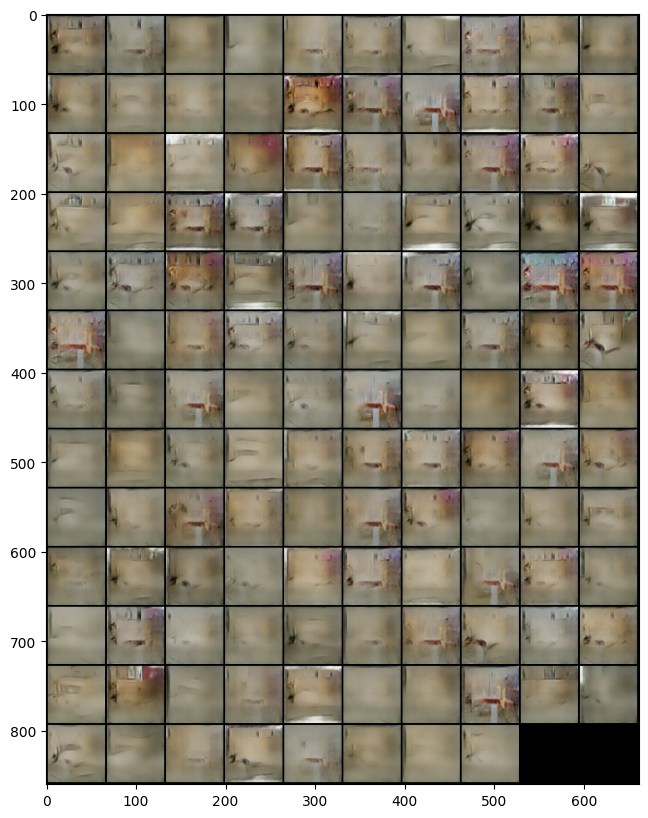

In [34]:
n_output=128
z_sample=torch.rand(n_output,z_dim).cuda()
imgs_sample=(G(z_sample).data+1)/2

grid_img=torchvision.utils.make_grid(imgs_sample.cpu(),nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1,2,0))
plt.show()